# first test model

We try here to clasify the waves to language

In [2]:
import torch
import polars as pl
import numpy as np
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dfTrain = pl.read_csv("../data/train_clean.csv").sample(fraction=0.01, shuffle=True)
dfTrain.head()

shape: (5, 4)
┌───────────┬─────────────────────────────────┬───────────────┬───────┐
│ client_id ┆ path                            ┆ language      ┆ label │
│ ---       ┆ ---                             ┆ ---           ┆ ---   │
│ i64       ┆ str                             ┆ str           ┆ i64   │
╞═══════════╪═════════════════════════════════╪═══════════════╪═══════╡
│ 572       ┆ /Swedish/train/swd_trn_sp_100/… ┆ Swedish       ┆ 22    │
│ 69        ┆ /Chinese_China/train/chch_trn_… ┆ Chinese_China ┆ 40    │
│ 556       ┆ /Romanian/train/rmn_trn_sp_43/… ┆ Romanian      ┆ 29    │
│ 607       ┆ /Kyrgyz/train/kyr_trn_sp_83/co… ┆ Kyrgyz        ┆ 16    │
│ 27        ┆ /Italian/train/itln_trn_sp_27/… ┆ Italian       ┆ 14    │
└───────────┴─────────────────────────────────┴───────────────┴───────┘

In [6]:
len(dfTrain)

221

## Dataset

this class take the raw audio and resample it to fit the SAMPLE_RATE needed. Insted of VoiceDataset, who transforme the audio into a spectograme.The goal here is to have raw audio to apply wav2vec2.

In [71]:
import IPython
import torch
from torch.utils.data import Dataset
import torchaudio

SAMPLE_RATE = 16000

class AudioDataset(Dataset):
    def __init__(self, df, root=""):
        self.paths = df["path"]
        self.labels = df["label"]
        self.root = root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.root + self.paths[idx])

        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(
                waveform, sr, SAMPLE_RATE
            )
        label = self.labels[idx]

        return waveform, label

dataset = AudioDataset(dfTrain, root="../data/common_voice_kpd")

In [ ]:
dataset = AudioDataset(dfTrain, root="../data/common_voice_kpd")
dataset[2079][0].shape

torch.Size([1, 41472])

In [76]:
IPython.display.Audio("../data/common_voice_kpd/Persian/train/prsh_trn_sp_32/common_voice_fa_19305134.wav")

In [ ]:
BUNDLE = torchaudio.pipelines.WAV2VEC2_XLSR_300M
WAV2VEC2_MODEL = BUNDLE.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_xlsr_300m.pth" to /home/ilian/.cache/torch/hub/checkpoints/wav2vec2_xlsr_300m.pth


100%|██████████| 1.18G/1.18G [00:46<00:00, 27.0MB/s]


In [50]:
data = dataset[208][0][0,0:16000*3].reshape(1, -1)
print(data.shape)
with torch.inference_mode():
    features, _ = WAV2VEC2_MODEL.extract_features(data)

features[1].shape, len(features)

torch.Size([1, 36096])


(torch.Size([1, 112, 1024]), 24)

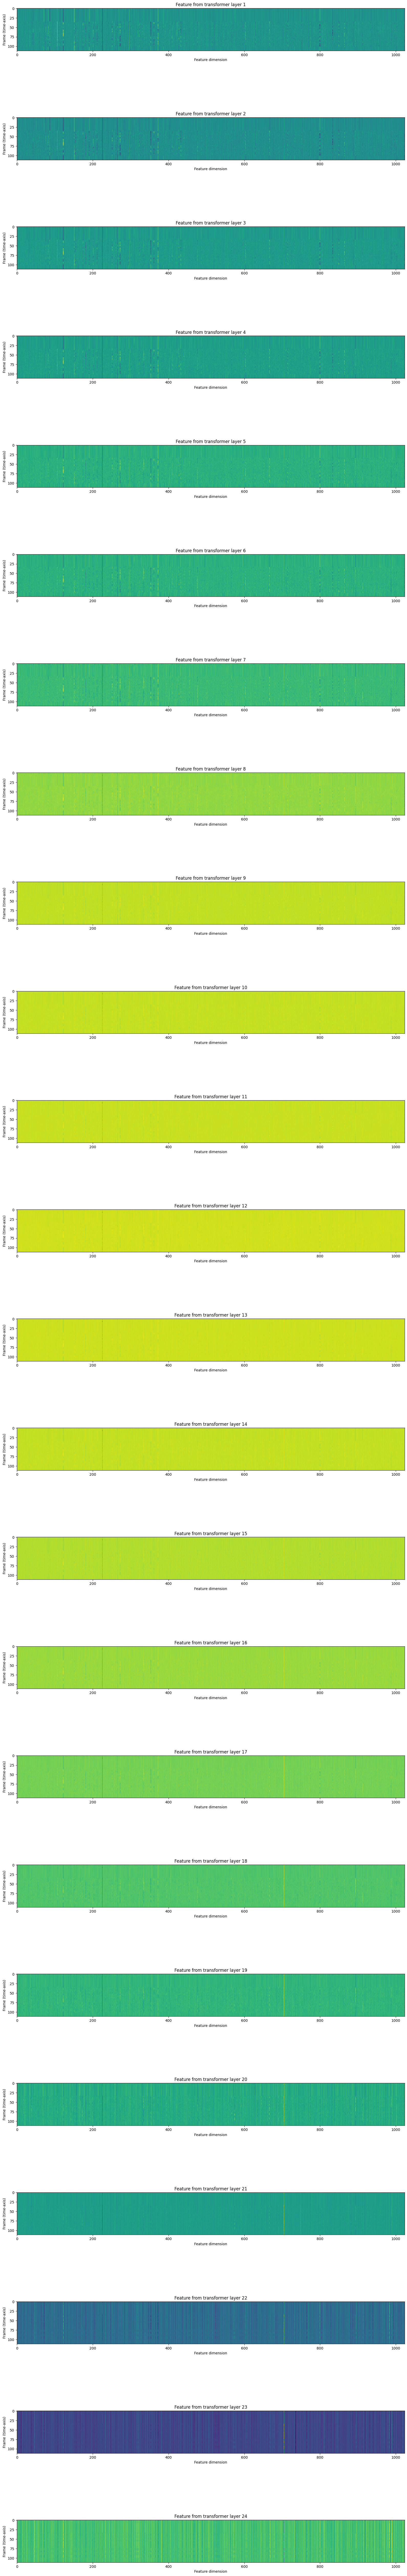

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [25]:
with torch.inference_mode():
    emission, _ = WAV2VEC2_MODEL(dataset[778][0])

emission.shape

torch.Size([1, 518, 29])

## Convolution Neural Network

we have translate audio into 24 images of (149,1024) pixel. Now we try to classify the data

In [96]:
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.optim as optim

CONV_LAYERS = [
    [1, 4, 3, 1, 1],
    [4, 8, 3, 1, 1],
    [8, 16, 3, 1, 1]
]

class LargeLanguageMappingModel(nn.Module):
    def __init__(self, conv_layers=CONV_LAYERS, input_dim=(24,149,1024)):
        super(LargeLanguageMappingModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 4)),  # -> (32, 12, 74, 256)

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 4)),  # -> (64, 6, 37, 64)

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),  # -> (128, 3, 18, 32)

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # -> (256, 1, 1, 1)
        )
        self.fc = nn.Linear(256, 45)

    def forward(self, x):
        x = x.unsqueeze(1)  # Ajouter une dimension de canal
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def fit(self, dataLoader:DataLoader, lossFunc:str="mseloss",
            opt:str ="adam", nepochs:int=20):

        crit_methods={
            "mseloss":nn.MSELoss,
            "l1loss":nn.L1Loss,
            "cel":nn.CrossEntropyLoss,
            "bcel":nn.BCELoss,
            "smoothl1loss":nn.SmoothL1Loss
        }
        if lossFunc not in crit_methods:
            lossFunc = "mseloss"
        criterion = crit_methods[lossFunc]()

        optim_methods = {
            "adam":optim.Adam,
            "sgd":optim.SGD
        }
        if opt not in optim_methods:
            opt = "adam"
        optimizer = optim_methods[opt](self.parameters(), lr=1e-3)
        
        progress =tqdm(range(nepochs*len(dataLoader)))
        result=[]
        for epoch in range(nepochs):
            self.train()
            total_loss = 0

            for batch, labels in dataLoader:

                outputs = self(batch)
                tqdm.write(f"labels: {labels}")
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                progress.update()
                progress.refresh()

            tqdm.write(f"Epoch [{epoch+1}/{nepochs}], Loss: {total_loss/len(dataLoader):.6f}")
            result.append([f"Epoch [{epoch+1}/{nepochs}]", total_loss/len(dataLoader)])
        progress.close()
        return result


In [84]:
import torch
from torch.utils.data import Dataset
import torchaudio
import torch.nn.functional as F

BUNDLE = torchaudio.pipelines.WAV2VEC2_XLSR_300M
WAV2VEC2_MODEL = BUNDLE.get_model()
WAV2VEC2_MODEL.eval()

SAMPLE_RATE = 16000
TARGET_LEN = SAMPLE_RATE * 3

class FeaturesDataset(Dataset):
    def __init__(self, df, root=""):
        self.paths = df["path"]
        self.labels = df["label"]
        self.root = root

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.root + self.paths[idx])

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(
                waveform, sr, SAMPLE_RATE
            )

        T = waveform.shape[1]

        if T < TARGET_LEN:
            waveform = F.pad(waveform, (0, TARGET_LEN - T))
        else:
            start = (T - TARGET_LEN) // 2
            waveform = waveform[:, start:start + TARGET_LEN]

        with torch.inference_mode():
            features, _ = WAV2VEC2_MODEL.extract_features(
                waveform
            )

        x = torch.stack(features, dim=0)
        x = x.squeeze(1)

        label = self.labels[idx]

        return x, label

In [ ]:
dsTrain = FeaturesDataset(dfTrain, root="../data/common_voice_kpd")
dsTrain[0][0].shape

torch.Size([24, 149, 1024])

In [88]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    FeaturesDataset(dfTrain, root="../data/common_voice_kpd"),
    batch_size=8,
    shuffle=True,
)

test_loader = DataLoader(
    FeaturesDataset(pl.read_csv("../data/test_clean.csv").sample(fraction=1.0, shuffle=True), root="../data/common_voice_kpd"),
    batch_size=8,
    shuffle=False,
)


In [ ]:
model = LargeLanguageMappingModel()
model.fit(train_loader, lossFunc="cel", opt="adam", nepochs=5)